# Raport - Metody generowania zmiennych losowych
Aleksandra Palka


In [17]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sb
from statsmodels import api
from time import time
from scipy.special import gamma
import random

# Wstęp
W raporcie przedstawimy różne metody generowania zmiennych losowych:
* odwracania dystrybuanty,
* akceptacji-odrzucenia,
* Boxa-Mullera, biegunową dla rozkładu normalnego,
* algorytm Ziggurat.

**Funkcje do wizualizacji danych z rozkładów dyskretynych:**
1. funkcja wykorzystywana podczas tworzenia wykresów prawodopodobieństw zmiennej losowej, służy do zliczania częstości występowania przyjmowanych przez nią wartości.

In [18]:
def pmf(xn, S):
    return np.array([np.count_nonzero(S == x) for x in xn])/len(S)

2. funkcja wykorzystywana podczas tworzenia wykresów dystrybuant, służy do:
- dodawania wartości: o 1 mniejszej od najmnieszej wartości przyjmowanej przez zmienną losową, o 1 większej od największej wartości przyjmowanej przez zmienną losową kolejno na początek i koniec listy wartości przyjmowanych przez tą zmienną losową,
- tworzy listę wartości "schodków" dystrybuanty zmiennej losowej oraz dodaje dwa 0 na początek tej listy.

In [19]:
def distribution(k, p):
    k = np.insert(k, 0, k[0]-1)
    k = np.append(k, k[-1]+1)
    y = np.array([sum(p[:i+1]) for i in range(len(p))])
    y = np.insert(y, [0, 0], 0)
    return k, y

# 1. Metoda odwracania dystrybuanty

### 1.1 Rozłady dyskretne
**Cel:** Chcemy wygenerować realizacje zmienej losowej X o rozkładzie dyskretnym $P(X=i)=p_i$ i dystrybuancie $F_X(x)$.

**Algorytm:**
1. Generuj $U \sim U(0,1)$.
2. Wyznacz $j=1,2,...$ tż. $\sum_{i=1}^{j-1} p_i < U \leq \sum_{i=1}^{j} p_i$ albo $F_X(x_{j-1}) \le U \leq F_X(x_j)$.
3. Zwróć $X=x_j$.

**Przykład:**

Chcemy generować realizacje zmiennej losowej X o rozkładzie geometrycznym $Geo(p)$ (gdzie $p_i = p(1-p)^i, i=0,1,...$).

Następnie wyznaczamy $j$, czyli
$$ \sum_{i=0}^{j-1} p_i < U \leq \sum_{i=0}^{j} p_i \Leftrightarrow j < \frac{\ln{1-U}}{\ln{1-p}} \leq j+1 \Leftrightarrow 
j = \left\lfloor \frac{\ln{1-U}}{\ln{1-p}} \right\rfloor. $$
A zatem będziemy wstawiać 
$$ X = \left\lfloor \frac{\ln{1-U}}{\ln{1-p}} \right\rfloor \stackrel{d}{=} \left\lfloor \frac{\ln{U}}{\ln{1-p}} \right\rfloor. $$
Teraz możemy przejść już do implementowania funkcji generującej realizacje zmiennej losowej $X$.

In [20]:
def geometric_distribution(p, n=1):
    return np.floor(np.log(np.random.random(n)) / np.log(1-p))

Testy $X \sim Geo(p=0.5)$

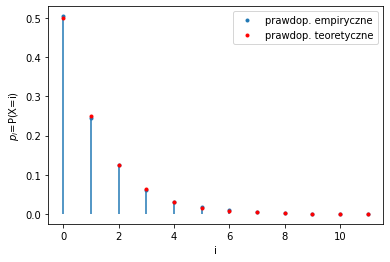

In [21]:
p = 0.5
X = geometric_distribution(p, 10**4)
n = max(X)
xn = np.arange(0, n+1, 1)
pk = stats.geom.pmf(xn+1, p)
P = pmf(xn, X)

plt.vlines(xn, 0, P)
plt.plot(xn, P, '.', label='prawdop. empiryczne')
plt.plot(xn, pk, 'r.', label='prawdop. teoretyczne')
plt.xlabel("i")
plt.ylabel("$p_i$=P(X=i)")
plt.legend()
plt.show()

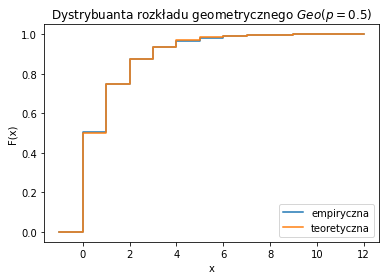

In [22]:
x1, y1 = distribution(xn, P)
x2, y2 = distribution(xn, pk)

plt.step(x1, y1, label='empiryczna')
plt.step(x2, y2, label='teoretyczna')
plt.legend()
plt.title(f'Dystrybuanta rozkładu geometrycznego $Geo(p={p})$')
plt.xlabel('x')
plt.ylabel('F(x)')
plt.show()

In [23]:
f'Teoretyczna wartość oczekiwana: {(1-p)/p}. Empiryczna wartość oczekiwana: {np.mean(X)}.'

'Teoretyczna wartość oczekiwana: 1.0. Empiryczna wartość oczekiwana: 1.0.'

In [24]:
f'Wariancja teoretyczna to: {(1-p)/p*2}. Wariancja empiryczna to: {np.var(X)}.'

'Wariancja teoretyczna to: 2.0. Wariancja empiryczna to: 2.0144.'

Wartości empiryczne $p_i, i=1,2..$ są bardzo bliskie wartościom teoretycznym, wykresy dystrybuant pokrywają się oraz wartość średnia i wariancją również są zbliżone. 

### 1.2. Rozkłady ciągłe
**Cel:** chcemy wygenerować X o znanej dystrybuancie $F_X$:
* gdy $X$ ma ściśle rosnącą dystrybuantę wyznaczamy dystrybuantę odwrotną:
    $F_X^{-1}(y) = \{x \in \R : y=F_X(x)\}$,
* gdy  $F_X$ nie jest ściśle rosnąca generujemy dystrybuantę uogólnioną odwrotną:
    $\tilde{F}_X^{-1}(y) = inf \{x \in \R : y \leq F_X(x)\}$.

**Algorytm:**
1. Generuj $U \sim U(0,1)$
2. Wstaw $X = F_X^{-1}(U) \ / \ \tilde{F}_X^{-1}(U)$


**Przykład:** 

Chcemy generować realizacje zmiennej losowej X o rozkładzie Weibulla $W(\lambda, p)$, dystrybuanta tego rozkładu dana jest wzorem:
$$F(x)=1-\mathrm{e}^{-(\lambda x)^p} , \ \mathrm{dla} \ x \ge 0 .$$
Wyznaczymy dystrybuantę odwrotną:
$$F^{-1}(x) = \frac{-\ln(1-x)}{\lambda p}, \ \mathrm{dla} \ x \ge 0 .$$
Teraz możemy przejść już do implementowania funkcji generującej realizacje zmiennej losowej $X$, wstawiając $X = \frac{-\ln(1-U)}{\lambda p}, U \sim U(0,1)$.

In [25]:
def weibull(l, p, N):
    X = np.random.random(N)
    return -np.log((1-X))/(l*p)

Testy $X \sim W(\lambda=10, p=1)$

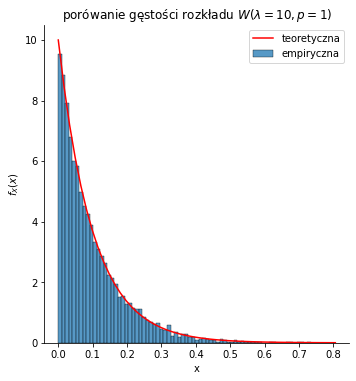

In [26]:
l=10
p=1
X = weibull(l,p, 10**4)

sb.displot(X, stat='density', label = "empiryczna")
x_w = np.linspace(min(X),max(X))
plt.plot(x_w, stats.weibull_min.pdf(x_w,c=p,scale=1/l), 'r', label="teoretyczna")
plt.legend()
plt.xlabel("x")
plt.ylabel("$f_X(x)$")
plt.title(f'porówanie gęstości rozkładu $W(\lambda={l}, p={p})$')
plt.show()

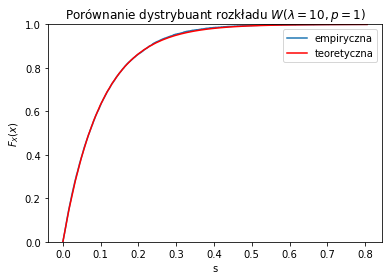

In [27]:
sb.ecdfplot(X, label="empiryczna")
plt.plot(x_w, stats.weibull_min.cdf(x_w,c =p,scale=1/l),'r', label="teoretyczna")
plt.legend()
plt.xlabel("s")
plt.ylabel("$F_X(x)$")
plt.title(f'Porównanie dystrybuant rozkładu $W(\lambda={l}, p={p})$')
plt.show()

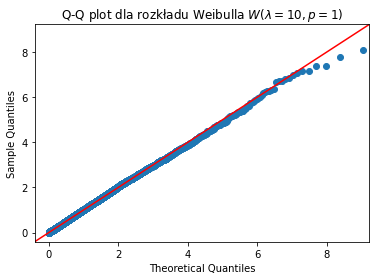

In [28]:
api.qqplot(X, stats.weibull_min, fit=True, line='45')
plt.title(f'Q-Q plot dla rozkładu Weibulla $W(\lambda={l}, p={p})$')
plt.show()

In [29]:
f'Teoretyczna wartość oczekiwana: 0.1. Empiryczna wartość oczekiwana: {np.mean(X)}.'

'Teoretyczna wartość oczekiwana: 0.1. Empiryczna wartość oczekiwana: 0.09908526544962853.'

In [30]:
f'Wariancja teoretyczna to: 0.01. Wariancja empiryczna to: {np.var(X)}.'

'Wariancja teoretyczna to: 0.01. Wariancja empiryczna to: 0.009404334189153946.'

Wykresy gęstości oraz dystrybuant pokrywają się oraz wartości kwantyli, wartości średnia i wariancji są zbliżone do wartości teoretycznych. 

# 2. Metoda akceptacji odrzucenia

### 2.1 Rozkłady dyskretne
**Cel:** Chcemy generować zmienną losową X o rozkładzie $ p_i = P(X=i), i=1,2,... $ $\left( \sum_{i=1}^{\infty} p_i = 1 \right)$.

**Założenia:** 
1. Potrafimy efektywnie generować realizację innej zmiennej losowej $Y$ o rozkłądzie $ q_i = P(Y=i), i=1,2,... $ $\left( \sum_{i=1}^{\infty} q_i = 1 \right)$ takiej, która ma taki sam zbiór wartości jak zmienna losowa $X$.
2. Istnieje stała $ 0<c<\infty $ taka, że $ max_i \frac{p_i}{q_i} \leq c $.

**Algorytm:**
1. Generuj $Y$.
2. Generuj $ U \sim U(0,1) $ niezależną od $Y$.
3. Jeśli $ U \leq \frac{p_Y}{c \cdot q_Y} $, zwróć $X=Y$, w przeciwnym razie wróć do 1.

**Przykład:** 

Chcemy generować realizacje zmiennej losowej X o rozkładzie Poissona $P(\lambda)$, $ \lambda>0$ $( p_i = \frac{\lambda^i}{i!} \mathrm{e}^{-\lambda}, i=0,1,... )$. Jako rozkład pomocniczy wybieramy rozkład geometryczny $Y \sim Geo(p)$ $(q_i = p(1-p)^i, i=0,1,...)$ z takim parametrem $p$, aby wartości oczekiwane zmiennych losowych $X$ $(EX = \lambda)$ i $Y$ $( EY = \frac{1-p}{p})$ były takie same. A zatem
$$ EX = EY \Leftrightarrow p = \frac{1}{\lambda + 1}. $$
Tak więc $Y \sim Geo(\frac{1}{\lambda + 1})$ z $q_i = \frac{\lambda^i}{(\lambda+1)^{i+1}}$. Realizacje zmiennej losowej $Y$ będziemy generować funkcją zaimplementowaną w przykładzie z paragrafu 1.1.

Teraz przejdziemy do wyznaczenia stałej $c$, czyli
$$ c = \max_{i=0,1,...}{\frac{p_i}{q_i}} = \mathrm{e}^{-\lambda} \max_{i=0,1,...}{ \frac{(\lambda+1)^{i+1}}{i!} } = \mathrm{e}^{-\lambda} \max_{i=0,1,...}{ a_i }. $$
Pokażemy, że $ a_i $ dla $ i=0,1,...$ osiąga wartość maksymalną w $i=\lceil \lambda \rceil$. W tym celu stworzymy wykres wartości $i$ dla której $a_i$ jest maksmalne dla różnych wartości $\lambda>0$.

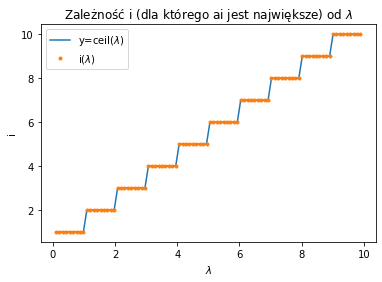

In [31]:
def _i_max(i, lam):
    temp = ((lam+1)**(i+1))/gamma(i+1)
    return i[temp==max(temp)][0]

def i_max(lam_seq, iend=100):
    i = np.arange(0, iend, 1, dtype='int32')
    return np.array([_i_max(i, lam) for lam in lam_seq])

lam_seq = np.arange(0.1, 10, 0.11)
i = i_max(lam_seq)
plt.plot(lam_seq, np.ceil(lam_seq), label='y=ceil($\lambda$)')
plt.plot(lam_seq, i, '.', label='i($\lambda$)')
plt.title('Zależność i (dla którego ai jest największe) od $\lambda$')
plt.xlabel('$\lambda$')
plt.ylabel('i')
plt.legend()
plt.show()

Zatem z wykresu widać, że $a_i$ jest maksymalne dla $i= \lceil \lambda \rceil$, tak więc możemy zapisać, że
$$ c = \mathrm{e}^{-\lambda} a_{\lceil \lambda \rceil} = \mathrm{e}^{-\lambda} \frac{(\lambda+1)^{\lceil \lambda \rceil+1}}{\lceil \lambda \rceil!}. $$
Wyznaczymy jeszcze 
$$ \frac{p_i}{c q_i} = \frac{\lceil \lambda \rceil!}{k!} (\lambda+1)^{k-\lceil \lambda \rceil}. $$
Teraz możemy przejść już do implementowania funkcji generującej realizacje zmiennej losowej z rozkładu Poissona $P(\lambda)$.

In [32]:
def poisson_distribution(lam, size):
    temp = gamma(np.ceil(lam)+1)
    f = lambda k: temp / gamma(k+1) * (lam+1)**(k-np.ceil(lam))
    result = np.zeros(size)

    for i in range(size):
        while True:
            Y = geometric_distribution(1/(lam+1))
            U = np.random.random() 
            if U <= f(Y):
                result[i] = Y
                break
    return result

Testy $X \sim P(\lambda=5)$ .

In [33]:
lam = 5
size = 10**4
X = poisson_distribution(lam, 10**4)

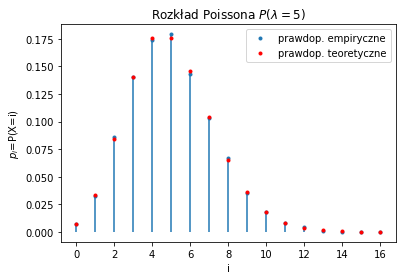

In [34]:
n = max(X)
xn = np.arange(0, n+1, 1)
pk = stats.poisson.pmf(xn, lam)
P = pmf(xn, X)
plt.vlines(xn, 0, P)
plt.plot(xn, P, '.', label='prawdop. empiryczne')
plt.plot(xn, pk, 'r.', label='prawdop. teoretyczne')
plt.legend()
plt.title(f'Rozkład Poissona $P(\lambda={lam})$')
plt.xlabel('i')
plt.ylabel('$p_i$=P(X=i)')
plt.show()

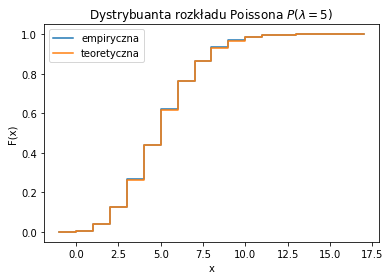

In [35]:
x1, y1 = distribution(xn, P)
x2, y2 = distribution(xn, pk)

plt.step(x1, y1, label='empiryczna')
plt.step(x2, y2, label='teoretyczna')
plt.legend()
plt.title(f'Dystrybuanta rozkładu Poissona $P(\lambda={lam})$')
plt.xlabel('x')
plt.ylabel('F(x)')
plt.show()

In [36]:
f'Teoretyczna wartość oczekiwana: {lam}. Empiryczna wartość oczekiwana: {np.mean(X)}.'

'Teoretyczna wartość oczekiwana: 5. Empiryczna wartość oczekiwana: 4.9895.'

In [37]:
f'Wariancja teoretyczna to: {lam}. Wariancja empiryczna to: {np.var(X)}.'

'Wariancja teoretyczna to: 5. Wariancja empiryczna to: 4.97178975.'

Wartości empiryczne $p_i, i=1,2..$ są bardzo bliskie wartościom teoretycznym, wykresy dystrybuant pokrywają się oraz wartość średnia i wariancją również są zbliżone. 

### 2.2 Rozkłady ciągłe

**Cel**: Chcemy generować realizacje zmiennej losowej $X$ o gęstości $f(x)$.

**Założenia:**
1. Potrafimy efektywnie generować inną zmienną losową $Y$ o gęstości $g(x)$. $X$ i $Y$ muszą przyjmować wartości z tego samego zbioru.
2. Potrafimy wyznaczyć stałą $c$ taką, że $ sup_{x \in \R} \frac{f(x)}{g(x)} \leq c < \infty $.

**Algorytm:**
1. Generuj $Y$.
2. Generuj $ U \sim U(0, 1) $ takie, że $U$ i $Y$ są niezależne.
3. Jeśli $ U \leq \frac{f(Y)}{c \cdot g(Y)} $, zwróć $X=Y$. W przeciwnym wypadku wróć do 1.

**Przykład:**

Chcemy generować zmienną losową X o rozkładzie Weibulla $W(\lambda, 2)$, $ \lambda>0$. Jako rozkład pomocniczy wybieramy rozkład wykładniczy $Exp(1)$.

Gęstość zmiennej losowej $ X \sim W(\lambda, 2) $ wynosi $ f(x) = 2 \lambda^2 x \mathrm{e}^{-(\lambda x)^2} $ dla $x \geq 0$. <br>
Skorzystamy z własności: $ X \sim W(\lambda, 2) \Leftrightarrow \lambda X \sim W(1, 2) $. Będziemy dalej rozpatrywać zmienną losową $\lambda X$ o gęstości 
$$ f_{\lambda X}(x) = 2x \mathrm{e}^{-x^2} \text{ dla  } x \geq 0. $$

Zmienną losową $Y \sim Exp(\lambda)$, o gęstości $g(x)=\lambda \mathrm{e}^{-\lambda x}$ i dystrybuancie $F_Y (x)=1-\mathrm{e}^{-\lambda x}$, będziemy generować metodą odwrotnej dystrybuanty w następujący sposób:
$$ y = F_{Y}(x) \Leftrightarrow x = -\frac{1}{\lambda} \ln{(1-y)}. $$
Wtedy otrzymujemy, że
$$ X \overset{d}{=} -\frac{1}{\lambda} \ln{(1-U)} \overset{d}{=} -\frac{1}{\lambda} \ln{(U)}, $$
bo dla rozkładu jednostajnego jest spełniona następująca własność: $ 1-U \overset{d}{=} U $. Teraz korzystając z algorytmu z paragrafu 1.2, możemy napisać funkcję generującą realizacje zmiennej losowej z rozkładu wykładniczego $Exp(\lambda)$.

In [38]:
def exponential_distribution(n=1, lam=1):
    return -np.log(np.random.random(n)) / lam

Następnie przejdziemy do wyznaczenia stałej $c$, a zatem
$$ c = \sup_{x \in \R}{\frac{f_{\lambda X}(x)}{g(x)}} = \sup_{x \geq 0}{2x\mathrm{e}^{-x^2+x}} = \sup_{x \geq 0}{h(x)}. $$
Zatem $c$ będzie równe wartości maksymalnej funkcji $h(x)$ na przedziale $[0, \infty)$. Aby ją wyznaczyć, przyrównamy pochodną $h'(x)$ do 0 i sprawdzimy jej monotoniczność, czyli
$$ h'(x) = -4\mathrm{e}^{-x^2+x}(x-1) = 0 \Leftrightarrow x = 1. $$
Na przedziale 
- $[0, 1)$ $h'(x) > 0$,
 - $(1, \infty)$ $h'(x) < 0$,

 a zatem w $x=1$ funkcja $h(x)$ ma wartość maksymalną na przedziale $[0, \infty)$, czyli
 $$ c = h(1) = 2. $$

Teraz możemy przejść już do implementowania funkcji generującej realizacje zmiennej losowej z rozkładu Weibulla $W(\lambda, 2)$.


In [39]:
def weibull_distrubution(size, lam=1):
    f = lambda x: 2 * x * np.exp(-x**2)
    g = lambda x: np.exp(-x)
    result = np.zeros(size)
    c = 2
    for i in range(size):
        while True:
            Y = exponential_distribution()
            U = np.random.random()
            if U <= (f(Y)/(c*g(Y))):
                result[i] = Y
                break
    return result / lam

Testy $X \sim W(\lambda=2,2)$.

In [40]:
np.random.seed(12345)
size = 10**4
p = 2
lam = 2
X = weibull_distrubution(size, lam)

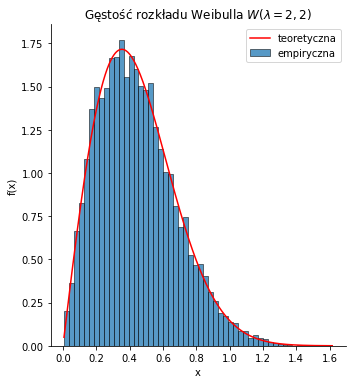

In [41]:
sb.displot(X, stat='density', label='empiryczna')
x = np.linspace(min(X), max(X), size)
plt.plot(x, stats.weibull_min.pdf(x, p, scale=1/lam), 'r', label='teoretyczna')
plt.title(f'Gęstość rozkładu Weibulla $W(\lambda={lam}, 2)$')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.legend()
plt.show()

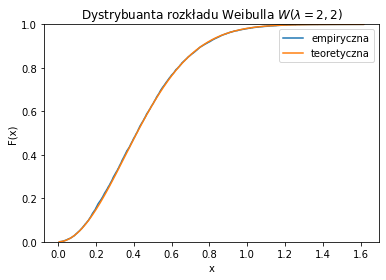

In [42]:
sb.ecdfplot(X, label='empiryczna')
plt.plot(x, stats.weibull_min.cdf(x, p, scale=1/lam), label='teoretyczna')
plt.title(f'Dystrybuanta rozkładu Weibulla $W(\lambda={lam}, 2)$')
plt.xlabel('x')
plt.ylabel('F(x)')
plt.legend()
plt.show()

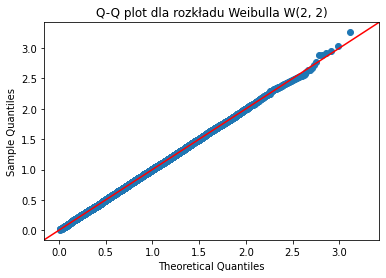

In [43]:
api.qqplot(X, stats.weibull_min, fit=True, line='45')
plt.title(f'Q-Q plot dla rozkładu Weibulla W({lam}, 2)')
plt.show()

In [44]:
f'Teoretyczna wartość oczekiwana: {np.sqrt(np.pi)/2/lam}. Empiryczna wartość oczekiwana: {np.mean(X)}.'

'Teoretyczna wartość oczekiwana: 0.44311346272637897. Empiryczna wartość oczekiwana: 0.4415042974344319.'

In [45]:
f'Wariancja teoretyczna to: {(np.sqrt(np.pi)/2 - np.pi/4)/lam**2}. Wariancja empiryczna to: {np.var(X)}.'

'Wariancja teoretyczna to: 0.025207190513827415. Wariancja empiryczna to: 0.054644816549255064.'

Wykresy gęstości oraz dystrybuant pokrywają się oraz kwantyle, wartość średnia i wariancją są zbliżone do wartości teoretycznych. 

# 3. Metody generowania rozkładu normalnego

**Cel (każdej metody opisanej w tym parafrafie):** Chcemy generować zmienną losową z rozkładu normalnego $N(\mu, \sigma)$, gdzie $\mu$ to wartość oczekwiana, $\sigma$ to odchylenie standardowe.

**Własność:** $ X \sim N(0, 1) \Leftrightarrow \sigma X+\mu \sim N(\mu, \sigma) $.

Dzięki zmajomości powyższej własności, skupimy się na algorytmach generowania zmiennej losowej $X \sim N(0, 1) $.

### 3.0 Współczynik skośności i kurtoza

**Współczynnik skośności** jest miarą asymetrii rozkładu i możemy go policzyć ze wzoru
$$ \alpha = \frac{n}{(n-1)(n-2)} \sum_{i=1}^{n} \left(\frac{x_i-\bar{x}}{s} \right)^3, $$
gdzie $\bar{x}$ to średnia arytmetyczna, $s$ to odchylenie standardowe z próby. <br>
Wtedy
- $\alpha < 0$ wskazuje na lewostronną skośność,
- $\alpha = 0$ wskazuje na rozkład symetryczny (tyle wynosi dla rozkładu normalnego),
- $\alpha > 0$ wskazuje na prawostronną skośność.

In [46]:
def skosnosc(data):
    n = len(data)
    return n / ((n-1)*(n-2)) * sum(((data - np.mean(data))/np.std(data))**3)

**Kurtoza** jest miarą spłaszczenia rozkładu i możemy ją policzyć ze wzoru
$$ K = \frac{\frac{1}{n} \sum_{i=1}^{n} (x_i -\bar{x})^4}{\left(\frac{1}{n} \sum_{i=1}^{n} (x_i -\bar{x})^2\right)^2}, $$
gdzie $\bar{x}$ to średnia arytmetyczna z próby. <br>
Wtedy
- $K < 3$ wskazuje na rozkłąd lekkoogonowy,
- $K = 3$ intensywność wartości skrajnych jest podobna do tych dla rozkładu normalnego (dla rozkładu normalnego kurtoza wynosi właśnie 3),
- $K > 3$ wskazuje na rozkład ciężkoogonowy.

In [47]:
def kurtoza(data):
    m = np.mean(data)
    return np.mean((data-m)**4) / (np.var(data))**2

### 3.1 Metoda Boxa-Mullera

**Algorytm:**
1. Generuj $U_1 \sim U(0,1)$ i $U_2 \sim U(0,1)$ takie, że $U_1$ i $U_2$ są niezależne.
2. Wstaw $X=\sqrt{-2\ln{U_1}}\cos{2 \pi U_2}$, $Y=\sqrt{-2\ln{U_1}}\sin{2 \pi U_2}$.

Wtedy $X, Y \sim N(0, 1)$ oraz $X$ i $Y$ są niezależne.

In [48]:
def box_muller_method(n, mi=0, sigma=1):
    U1 = np.random.random(n)
    U2 = np.random.random(n)
    return np.sqrt(-2*np.log(U1))*np.cos(2*np.pi*U2)*sigma+mi, np.sqrt(-2*np.log(U1))*np.sin(2*np.pi*U2)*sigma+mi

mi = 0
sigma = 1
X, Y = box_muller_method(10**4, mi, sigma)

Testy $X \sim N(0,1)$

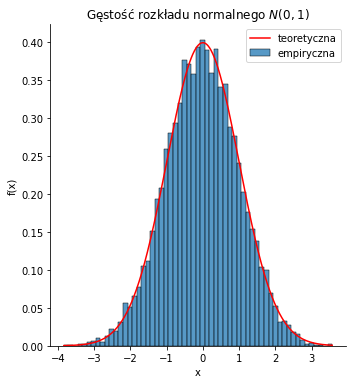

In [49]:
sb.displot(X, stat='density', label='empiryczna')
x = np.linspace(min(X), max(X), 10**3)
plt.plot(x, stats.norm.pdf(x), 'r', label='teoretyczna')
plt.title(f'Gęstość rozkładu normalnego $N({mi}, {sigma})$')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.legend()
plt.show()

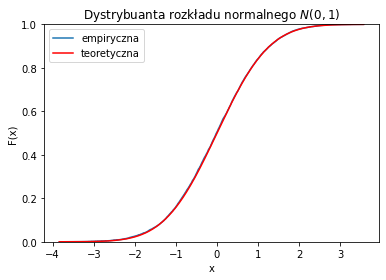

In [50]:
sb.ecdfplot(X, label='empiryczna')
plt.plot(x, stats.norm.cdf(x), 'r', label='teoretyczna')
plt.title(f'Dystrybuanta rozkładu normalnego $N({mi}, {sigma})$')
plt.xlabel('x')
plt.ylabel('F(x)')
plt.legend()
plt.show()


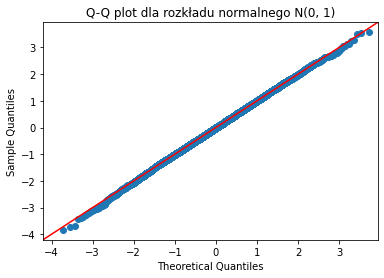

In [51]:
api.qqplot(X, stats.norm, line='45')
plt.title(f'Q-Q plot dla rozkładu normalnego N({mi}, {sigma})')
plt.show()

In [52]:
f'Teoretyczna wartość oczekiwana: 0. Empiryczna wartość oczekiwana: {np.mean(X)}.'

'Teoretyczna wartość oczekiwana: 0. Empiryczna wartość oczekiwana: -0.01174635504025343.'

In [53]:
f'Wariancja teoretyczna to: 1. Wariancja empiryczna to: {np.var(X)}.'

'Wariancja teoretyczna to: 1. Wariancja empiryczna to: 1.0136109897047927.'

In [54]:
f'Skośność rozkładu normalnego wynosi 0. Skośność próby wynosi {skosnosc(X)}'

'Skośność rozkładu normalnego wynosi 0. Skośność próby wynosi -0.031092912280357984'

In [55]:
f'Kurtoza rozkładu normalnego wynosi 3. Kurtoza próby wynosi {kurtoza(X)}'

'Kurtoza rozkładu normalnego wynosi 3. Kurtoza próby wynosi 2.9918973481123876'

Wykresy gęstości oraz dystrybuant pokrywają się oraz wartości kwantyli, wartości średnia i wariancji są zbliżone do wartości teoretycznych. Skośność wykresu jest bliska 0, a kurtoza 3, czyli wartości tych statystyk dla rozkładu normalnego.

Testy $Y \sim N(0,1)$

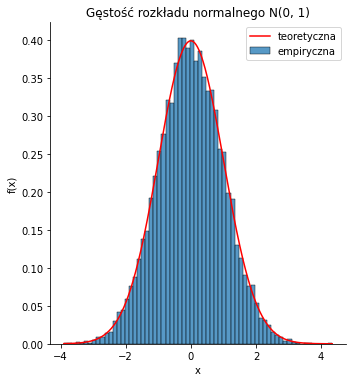

In [56]:
sb.displot(Y, stat='density', label='empiryczna')
y = np.linspace(min(Y), max(Y), 10**3)
plt.plot(y, stats.norm.pdf(y), 'r', label='teoretyczna')
plt.title(f'Gęstość rozkładu normalnego N({mi}, {sigma})')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.legend()
plt.show()

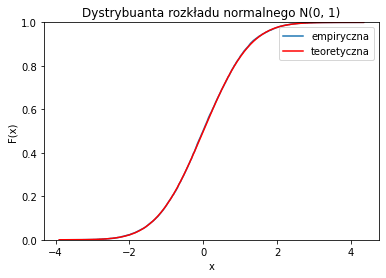

In [57]:
sb.ecdfplot(Y, label='empiryczna')
plt.plot(y, stats.norm.cdf(y), 'r', label='teoretyczna')
plt.title(f'Dystrybuanta rozkładu normalnego N({mi}, {sigma})')
plt.xlabel('x')
plt.ylabel('F(x)')
plt.legend()
plt.show()

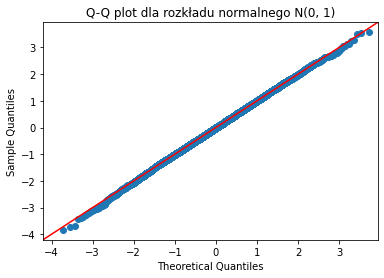

In [58]:
api.qqplot(X, stats.norm, line='45')
plt.title(f'Q-Q plot dla rozkładu normalnego N({mi}, {sigma})')
plt.show()

In [59]:
f'Teoretyczna wartość oczekiwana: 0. Empiryczna wartość oczekiwana: {np.mean(Y)}.'

'Teoretyczna wartość oczekiwana: 0. Empiryczna wartość oczekiwana: -0.003489874767017716.'

In [60]:
f'Wariancja teoretyczna to: 1. Wariancja empiryczna to: {np.var(Y)}.'

'Wariancja teoretyczna to: 1. Wariancja empiryczna to: 0.9979402233153489.'

In [61]:
f'Skośność rozkładu normalnego wynosi 0. Skośność próby wynosi {skosnosc(Y)}'

'Skośność rozkładu normalnego wynosi 0. Skośność próby wynosi 0.0035140452581131592'

In [62]:
f'Kurtoza rozkładu normalnego wynosi 3. Kurtoza próby wynosi {kurtoza(Y)}'

'Kurtoza rozkładu normalnego wynosi 3. Kurtoza próby wynosi 3.0306661415967517'

Wykresy gęstości oraz dystrybuant pokrywają się oraz wartości kwantyli, wartości średnia i wariancji są zbliżone do wartości teoretycznych. Skośność wykresu jest bliska 0, a kurtoza 3, czyli wartości tych statystyk dla rozkładu normalnego.

### 3.2 Metoda biegunowa

**Algorytm:**
1. Generuj $V_1 \sim U(-1, 1)$, $V_2 \sim U(-1, 1)$ takie, że $V_1$ i $V_2$ są niezależne.
2. Wyznacz $R^2=V_1^2 + V_2^2$.
3. Jeśli R^2 > 1, wróć do 1.
4. Wstaw $X=\sqrt{\frac{-2\ln{R^2}}{R^2}}V_1$, $Y=\sqrt{\frac{-2\ln{R^2}}{R^2}}V_2$.

Wtedy $X, Y \sim N(0, 1)$ oraz $X$ i $Y$ są niezależne.

In [63]:
def polar_method(n, mi=0, sigma=1):
    X = np.zeros(n)
    Y = np.zeros(n)
    for i in range(n):
        while True:
            V1 = np.random.uniform(-1, 1, 1)
            V2 = np.random.uniform(-1, 1, 1)
            R_square = V1**2 + V2**2

            if R_square <= 1:
                X[i] = np.sqrt(-2*np.log(R_square)/R_square)*V1
                Y[i] = np.sqrt(-2*np.log(R_square)/R_square)*V2
                break
    return X*sigma+mi, Y*sigma+mi
mi = 0
sigma = 1
X, Y = polar_method(10**4, mi, sigma)

Testy $X\sim N(0, 1)$

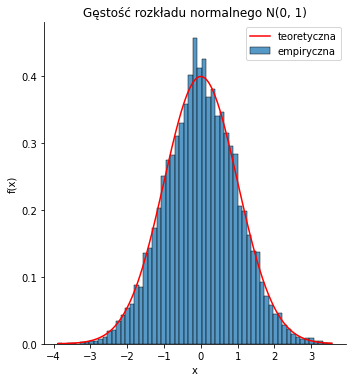

In [64]:
sb.displot(X, stat='density', label='empiryczna')
x = np.linspace(min(X), max(X), 10**3)
plt.plot(x, stats.norm.pdf(x, loc=mi, scale=sigma), 'r', label='teoretyczna')
plt.title(f'Gęstość rozkładu normalnego N({mi}, {sigma})')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.legend()
plt.show()

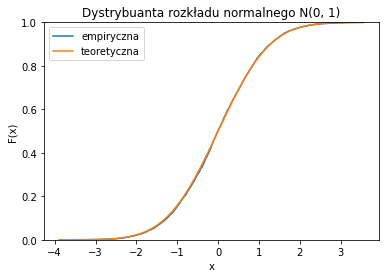

In [65]:
sb.ecdfplot(X, label='empiryczna')
plt.plot(x, stats.norm.cdf(x), label='teoretyczna')
plt.title(f'Dystrybuanta rozkładu normalnego N({mi}, {sigma})')
plt.xlabel('x')
plt.ylabel('F(x)')
plt.legend()
plt.show()

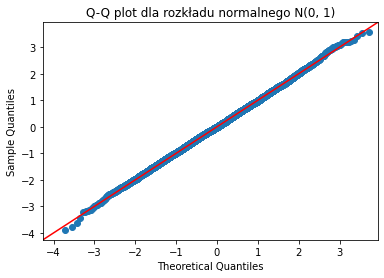

In [66]:
api.qqplot(X, stats.norm, line='45')
plt.title(f'Q-Q plot dla rozkładu normalnego N({mi}, {sigma})')
plt.show()

In [67]:
f'Teoretyczna wartość oczekiwana: 0. Empiryczna wartość oczekiwana: {np.mean(X)}.'

'Teoretyczna wartość oczekiwana: 0. Empiryczna wartość oczekiwana: 0.009849414044396943.'

In [68]:
f'Wariancja teoretyczna to: 1. Wariancja empiryczna to: {np.var(X)}.'

'Wariancja teoretyczna to: 1. Wariancja empiryczna to: 0.9792893621563661.'

In [69]:
f'Skośność rozkładu normalnego wynosi 0. Skośność próby wynosi {skosnosc(X)}'

'Skośność rozkładu normalnego wynosi 0. Skośność próby wynosi 0.02605227008145231'

In [70]:
f'Kurtoza rozkładu normalnego wynosi 3. Kurtoza próby wynosi {kurtoza(X)}'

'Kurtoza rozkładu normalnego wynosi 3. Kurtoza próby wynosi 3.0701154214337083'

Wykresy gęstości oraz dystrybuant pokrywają się oraz wartości kwantyli, wartości średnia i wariancji są zbliżone do wartości teoretycznych. Skośność wykresu jest bliska 0, a kurtoza 3, czyli wartości tych statystyk dla rozkładu normalnego.

Testy $Y \sim N(0, 1)$

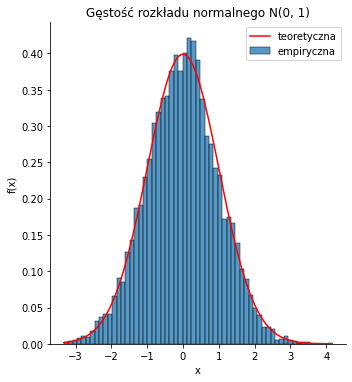

In [71]:
sb.displot(Y, stat='density', label='empiryczna')
y = np.linspace(min(Y), max(Y), 10**3)
plt.plot(y, stats.norm.pdf(y), 'r', label='teoretyczna')
plt.title(f'Gęstość rozkładu normalnego N({mi}, {sigma})')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.legend()
plt.show()

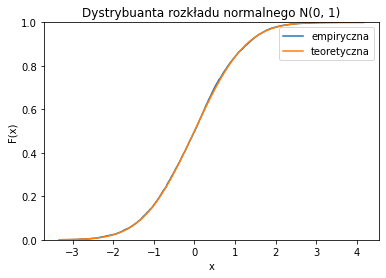

In [72]:
sb.ecdfplot(Y, label='empiryczna')
plt.plot(y, stats.norm.cdf(y), label='teoretyczna')
plt.title(f'Dystrybuanta rozkładu normalnego N({mi}, {sigma})')
plt.xlabel('x')
plt.ylabel('F(x)')
plt.legend()
plt.show()

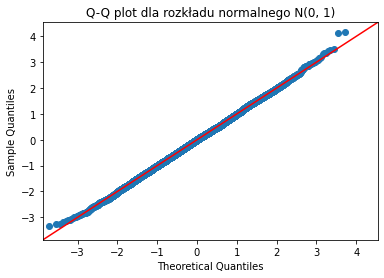

In [73]:
api.qqplot(Y, stats.norm, line='45')
plt.title(f'Q-Q plot dla rozkładu normalnego N({mi}, {sigma})')
plt.show()

In [74]:
f'Teoretyczna wartość oczekiwana: 0. Empiryczna wartość oczekiwana: {np.mean(Y)}.'

'Teoretyczna wartość oczekiwana: 0. Empiryczna wartość oczekiwana: -0.007208471819079835.'

In [75]:
f'Wariancja teoretyczna to: 1. Wariancja empiryczna to: {np.var(Y)}.'

'Wariancja teoretyczna to: 1. Wariancja empiryczna to: 1.006132080996196.'

In [76]:
f'Skośność rozkładu normalnego wynosi 0. Skośność próby wynosi {skosnosc(X)}'

'Skośność rozkładu normalnego wynosi 0. Skośność próby wynosi 0.02605227008145231'

In [77]:
f'Kurtoza rozkładu normalnego wynosi 3. Kurtoza próby wynosi {kurtoza(Y)}'

'Kurtoza rozkładu normalnego wynosi 3. Kurtoza próby wynosi 3.0130797906931086'

Wykresy gęstości oraz dystrybuant pokrywają się oraz wartości kwantyli, wartości średnia i wariancji są zbliżone do wartości teoretycznych. Skośność wykresu jest bliska 0, a kurtoza 3, czyli wartości tych statystyk dla rozkładu normalnego.

### 3.3 Metoda akceptacji-odrzucenia przy użyciu rozkładu wykładniczego

Do generowania realizacje zmiennej losowej $X \sim N(0,1)$ metodą akceptacji-odrzucenia, skorzystamy z algorytmu podanego w paragrafie 2.2. Rozkładem pomocniczym jest rozkład wykładniczy $(Y \sim Exp(1))$. Aby wartości przyjmowane przez $X$ i $Y$ były jednakowe, skorzystamy z symetryczności gęstości standardowego rozkładu normalnego względem 0 i początkowo wygenerujemy zmienną losową $Z=|X|$. Wtedy gęstość $Z$ wynosi $ f_Z(x) = \frac{2}{\sqrt{2\pi}} \mathrm{e}^{-0.5x^2} $. Następnie z prawdopodobieństwem wynoszącym 0.5 zmienimy znak wygenerowanej zmiennej losowej na przeciwny i  w ten sposób otrzymamy funkcję generującą realizacje $X \sim N(0, 1)$.

Zaczniemy od wyznaczenia $c$, czyli
$$ c = \sup_{x \in \R}{\frac{f_Z(x)}{g(x)}} = \frac{2}{\sqrt{2\pi}} \sup_{x \geq 0}{\mathrm{e}^{-0.5x^2+x}}. $$
Wartość maksymalna funkcji $y=\mathrm{e}^{-0.5x^2+x}=\mathrm{e}^{h(x)}$ będzie w wierzchołku funkcji $h(x)$, czyli w $x=1$, a zatem
$$ c = \sqrt{\frac{2 \mathrm{e}}{\pi}}. $$
Teraz możemy przejść już do implementowania funkcji generującej realizacje $X$.

In [78]:
def acceptance_rejection_method(n, mi=0, sigma=1):
    norm_pdf = lambda x: 2/np.sqrt(2*np.pi) * np.exp(-x**2/2)
    exp_pdf = lambda x: np.exp(-x)
    
    result = np.zeros(n)
    c = np.sqrt(2*np.exp(1)/np.pi)

    for i in range(n):
        while True:
            Y = exponential_distribution(1)
            if np.random.random() <= norm_pdf(Y)/(c*exp_pdf(Y)):
                result[i] = Y if np.random.random() > 0.5 else -Y
                break
    return result*sigma + mi

Testy $X\sim N(0, 1)$

In [79]:
mi = 0
sigma = 1
N = acceptance_rejection_method(10**4, mi, sigma)

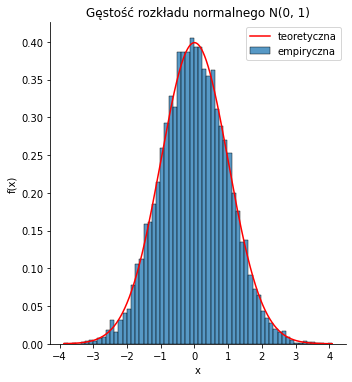

In [80]:
sb.displot(N, stat='density', label='empiryczna')
n = np.linspace(min(N), max(N), 10**3)
plt.plot(n, stats.norm.pdf(n), 'r', label='teoretyczna')
plt.title(f'Gęstość rozkładu normalnego N({mi}, {sigma})')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.legend()
plt.show()

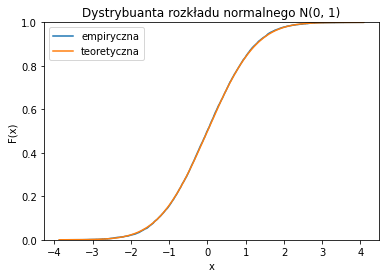

In [81]:
sb.ecdfplot(N, label='empiryczna')
plt.plot(n, stats.norm.cdf(n), label='teoretyczna')
plt.title(f'Dystrybuanta rozkładu normalnego N({mi}, {sigma})')
plt.xlabel('x')
plt.ylabel('F(x)')
plt.legend()
plt.show()

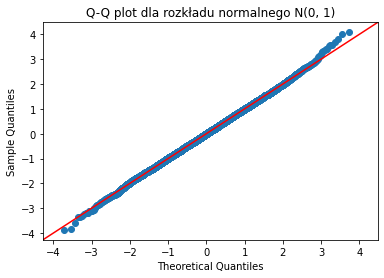

In [82]:
api.qqplot(N, stats.norm, line='45')
plt.title(f'Q-Q plot dla rozkładu normalnego N({mi}, {sigma})')
plt.show()

In [83]:
f'Teoretyczna wartość oczekiwana: 0. Empiryczna wartość oczekiwana: {np.mean(N)}.'

'Teoretyczna wartość oczekiwana: 0. Empiryczna wartość oczekiwana: -0.0024351637963546005.'

In [84]:
f'Wariancja teoretyczna to: 1. Wariancja empiryczna to: {np.var(N)}.'

'Wariancja teoretyczna to: 1. Wariancja empiryczna to: 0.9943580764775505.'

In [85]:
f'Skośność rozkładu normalnego wynosi 0. Skośność próby wynosi {skosnosc(N)}'

'Skośność rozkładu normalnego wynosi 0. Skośność próby wynosi 0.01988268102127474'

In [86]:
f'Kurtoza rozkładu normalnego wynosi 3. Kurtoza próby wynosi {kurtoza(N)}'

'Kurtoza rozkładu normalnego wynosi 3. Kurtoza próby wynosi 3.0984551870300514'

Wykresy gęstości oraz dystrybuant pokrywają się oraz wartości kwantyli, wartości średnia i wariancji są zbliżone do wartości teoretycznych. Skośność wykresu jest bliska 0, a kurtoza 3, czyli wartości tych statystyk dla rozkładu normalnego.

### 3.4 Porównanie metod generowania rozkładu normalnego ze względu na czas działania

Porównamy czas działania generatorów w zależności od długości próbki $k$.

In [87]:
def box_muller_method_time(n, size=100):
    total = 0
    for i in range(size):
        start = time()
        box_muller_method(n)
        end = time()
        total += end - start
    return total / size

def polar_method_time(n, size=100):
    total = 0
    for i in range(size):
        start = time()
        polar_method(n)
        end = time()
        total += end - start
    return total / size 

def acceptance_rejection_method_time(n, size=100):
    total = 0
    for i in range(size):
        start = time()
        acceptance_rejection_method(n)
        end = time()
        total += end - start
    return total / size 

k = np.arange(10, 10**3, 10)

In [88]:
# 1. metoda
bmm_time = np.array([box_muller_method_time(i) for i in k])

In [89]:
# 2. metoda
pm_time = np.array([polar_method_time(i) for i in k])

In [90]:
# 3. metoda
arm_time = np.array([acceptance_rejection_method_time(i) for i in k])

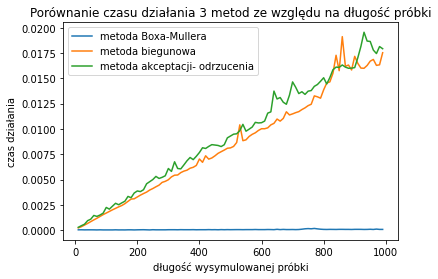

In [91]:
plt.plot(k, bmm_time, label='metoda Boxa-Mullera')
plt.plot(k, pm_time, label='metoda biegunowa')
plt.plot(k, arm_time, label='metoda akceptacji- odrzucenia')
plt.title('Porównanie czasu działania 3 metod ze względu na długość próbki')
plt.xlabel('długość wysymulowanej próbki')
plt.ylabel('czas działania')
plt.legend()
plt.show()

Porównując czas działania testowanych algorytmów możemy zauważyć znaczną przewagę metody Boxa-Mullera, która jest zdecydowanie szybsza od pozostałych.

## 4.Algorytm Ziggurat 


[[1](#bibliografia)]Obszar pod krzywą gęstości rozkładu $f(x)$ dzielimy na 256 prostokątów o równym polu $v$. Chcemy, aby ich suma ich pól była jak najbliższa polu pod krzywą. Przez $x_0 <x_1<...<x_{255}=r$ oznaczymy współrzędna $x$ prawej krawędzi wybranych prostokątów. Pola prostokątów są równe, więc:
$$v = x_i(f(x_i)-f(x_i)), i =1,2,..255, $$
oraz
\begin{equation} 
x_i = f^{-1}(\frac{v}{x_{i+1}}+f(x_{i+1})), i =254, ...,1
\end{equation}
Poniewaź pole ostatniego prostokąta i pozostała część pola pod wykresem(ogon rozkładu, dla $x>r$) również ma pole $v$, mamy:
$$v=rf(r)+ \int_r^\infty f(x)\mathrm{d}x$$

Znajdziemy $r$ szukając rozwiązania równania 
$$v(r)-x_1(r)(f(x_0)-f(x_1(r)))=0$$
metodą bisekcji[[2](#bibliografia)].

Następnie generujemy wektory $x$ z $(1)$ oraz $k$ i $w$, gdzie
$$k_0= \lfloor 2^{32}r\frac{f(r)}{v} \rfloor, k_i = \lfloor 2^{32}\frac{x_{i-1}}{x_i} \rfloor, i=1,...,255, $$
$$w_0=0.5^{32}\frac{v}{f(r)}, w_i = 0.5^{32}x_i, i=1,...,255 .$$


**Algorytm generowania**
1. Generuj 32 bitową liczbę całkowitą $j$, 8 ostatnich bitów zamień na liczbę całkowitą $i$.
2. Niech $x=j \cdot w_i$. Jeżeli $j \le k_i$, zwróć $x$.
3. Jeśli $i=0$ wygeneruj realizację z ogona rozkładu 
4. Jeśli $(f(x_{i-1})-f(x_i))u \le f(x) - f(x_i)$, gdzie $u \sim U(0,1)$, zwróć $x$.
5. Powróć do 1.



 

**Przykład**
Chcemy wygenerować zmienną losową z rozkładu Pareto $P(x_m=1, \alpha =2 )$ o gęstości $f(x)=\frac{\alpha x_m^\alpha}{x^{\alpha+1}}$ dla $x > x_m i dystrybuancie $F(x) = 1 - (\frac{x_m}{x})^\alpha$ dla $x>x_m .$

W punkcie (3) algorytmu realizację z ogona rozkładu będziemy generować za pomocą metody odwrotnej dystrybuanty, czyli zwracać takie 
$x = x_m(1-u)^{(-\frac{1}{\alpha})}$ gdzie $u \sim U(0,1)$, które są większe od obliczonego $r$. 

In [92]:
def f_pareto(x, xm, a):
    return a*xm**a/(x**(a+1))

def F_pareto(x, xm, a):
    return 1-(xm/x)**a

def f_pareto_odwrotna(x, xm, a):
    return (a*xm**a/x)**(1/(a+1))

def F_pareto_odwrotna(x,xm,a):
    return xm*(1-x)**(-1/a)

xm=1
a=4

def v(r, xm=1):
    return r*f_pareto(r,xm,a)+1-F_pareto(r,xm,a)

def x1(r):
    index = np.arange(255, 0, -1)
    x = np.zeros(256)
    x[255] = r
    for j in index:
        x[j-1] = f_pareto_odwrotna(v(r)/x[j] + f_pareto(x[j],xm,a),xm,a)
    return x[1]

def f_r(r, xm=1):
    return (v(r) +x1(r)*(-f_pareto(xm,xm,a)+f_pareto(x1(r),xm,a)))


def find_r():
    a = xm
    b = xm+20
    while abs(a-b) > 0.0000001:
        s = (a+b)/2
        y = f_r(s)
        if abs(y) < 0.0001:
            return s
        elif y > 0:
            a = s
        elif y <0:
            b = s
    return s

In [93]:
r12 = find_r()
r12

3.9972457885742188

In [94]:
v12 = v(r12)
v12

0.01958513591822164

Wyliczona wartość $r$ dla parametrów $\alpha=4, x_m =1 $ to 3.9972457885742188, wtedy v = 0.01958513591822164.

In [95]:
def generate_xkw(xm=1):
    r = find_r()
    v1 = v(r)
    index = np.arange(255, 0, -1)
    x = np.zeros(256)
    x[255] = r
    for j in index:
        x[j-1] = f_pareto_odwrotna(v1/x[j] + f_pareto(x[j],xm,a),xm,a)
    k = np.array([np.floor(2**32*r*f_pareto(r,xm,a)/v1)] + [np.floor(2**32*x[i-1]/x[i]) for i in range(1, len(x))])
    w = np.array([(0.5**32)*v1/f_pareto(r,xm,a)] + [(0.5**32)*x[i] for i in range(1, len(x))])
    return x, k, w

def ziggurat(N):
    r = find_r()
    x, k, w = generate_xkw()
    result = np.zeros(N)
    for n in range(N):
        while True:
            j=random.getrandbits(32)
            i = int(bin(j)[-8:], base=2)
            x_rand = j*w[i]
            if x_rand < 1: #
                pass
            elif j < k[i]:
                result[n] = x_rand 
                break
            elif i == 0:
                while True:
                    y_rand=F_pareto_odwrotna(np.random.random(),xm,a)
                    if y_rand > r:
                        result[n]=y_rand
                        break
                break
            elif (f_pareto(x[i-1],xm,a)-f_pareto(x[i],xm,a))*np.random.random() < f_pareto(x_rand,xm,a) - f_pareto(x[i],xm,a):
                result[n] = x_rand 
                break
    return result



Powstały podział na $x_i$ uzwględnia wartości mnniejsze od 1, i takie wartości generuje. Wybrany rozkład Pareto przyjmuje tylko wartości większe od 1, dlatego odrzucamy nieprawidłowe. 

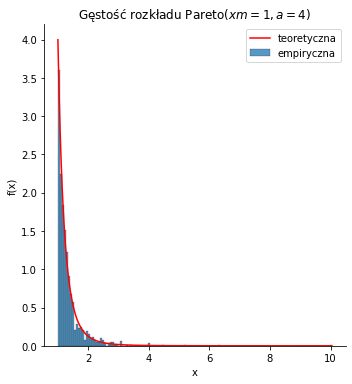

In [96]:
np.random.seed(1000)
X = ziggurat(10**3)
sb.displot(X, stat='density', label="empiryczna")
x = np.linspace(min(X), max(X), 10**3)
plt.plot(x, stats.pareto.pdf(x,b=a)*xm**a, 'r', label='teoretyczna')
plt.title(f'Gęstość rozkładu Pareto$(xm={xm},a={a})$')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.legend()
plt.show()
plt.show()

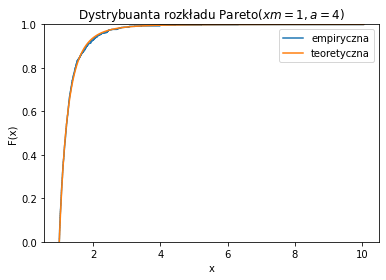

In [97]:
sb.ecdfplot(X, label='empiryczna')
plt.plot(x, stats.pareto.cdf(x,b=a), label='teoretyczna')
plt.title(f'Dystrybuanta rozkładu Pareto$(xm={xm},a={a})$')
plt.xlabel('x')
plt.ylabel('F(x)')
plt.legend()
plt.show()

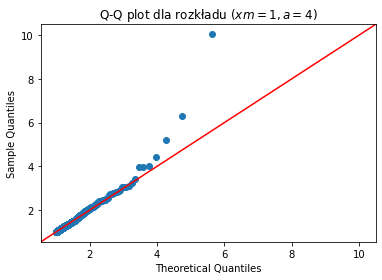

In [98]:
api.qqplot(X, stats.pareto(b=a), line='45')
plt.title(f'Q-Q plot dla rozkładu $(xm={xm},a={a})$')
plt.show()

In [99]:
f'Teoretyczna wartość oczekiwana (istnieje dla a>1): {a*xm/(a-1)}. Empiryczna wartość oczekiwana: {np.mean(X)}.'

'Teoretyczna wartość oczekiwana (istnieje dla a>1): 1.3333333333333333. Empiryczna wartość oczekiwana: 1.3423245093046006.'

In [100]:
f'Wariancja teoretyczna (istnieje dla a>2)to: {xm**2*a/((a-1)**2*(a-2))}. Wariancja empiryczna to: {np.var(X)}.'

'Wariancja teoretyczna (istnieje dla a>2)to: 0.2222222222222222. Wariancja empiryczna to: 0.28384505070234506.'

Wykresy gęstości oraz dystrybuant pokrywają się oraz wartości wartości średniej i wariancji są zbliżone do wartości teoretycznych.

Wartośći kwantyli są również zbliżone, przy dalszych pojawiają się czasami widoczne różnice. Być może popełniony został bład w implementacji, nie jesteśmy w stanie go jednak wskazać.

# Literatura
<a id="bibliografia"></a>
[1] George Marsaglia, Wai Wan Tsang, "The Ziggurat Method for Generating Random Variables"

[2] Jurgen A Doornik, ["An Improved Ziggurat Method to Generate Normal Random Samples"](https://www.doornik.com/research/ziggurat.pdf) 